**Libaries**

In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint
from sklearn.metrics import roc_curve, auc
from category_encoders import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from flask import Flask, render_template, request
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import pickle
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

**Feature Engineering for the Pipeline**

In [269]:
# Load data set and target variable

df = pd.read_csv('data/leads.csv')
target_variable = 'Converted'
missing_values = df.isnull().sum()
print(missing_values)

Prospect ID                            0
Lead Number                            0
Lead Origin                            0
Lead Source                            0
Do Not Email                           0
Do Not Call                            0
TotalVisits                          137
Total Time Spent on Website            0
Page Views Per Visit                 137
Last Activity                        986
Country                              907
Industry                            1438
How did you hear about us           2207
Search                                 0
Magazine                               0
Newspaper Article                      0
Forums                                 0
Newspaper                              0
Digital Advertisement                  0
Through Recommendations                0
Product Interested                     0
Lead Quality                        4767
Lead Profile                        2709
Asymmetrique Activity Index         4218
Asymmetrique Pro

In [270]:
# Dropping irrelevant columns
df.drop(['Prospect ID', 'Lead Number', 'Magazine'], axis=1, inplace=True)

In [271]:
# Convert Yes/No columns to 1/0

def binary_map(feature):
    return feature.map({'Yes':1, 'No':0})
binary_list = ['Do Not Email', 'Do Not Call', 'Search', 'Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations']
df[binary_list] = df[binary_list].apply(binary_map)

In [272]:
# Identify categorical features

categorical_columns = df.select_dtypes(include=['object']).columns

In [273]:
# Initialize SimpleImputer with strategy='most_frequent' for missing categorical variables

imputer = SimpleImputer(strategy='most_frequent')

# Apply imputation to each categorical column

df[categorical_columns] = imputer.fit_transform(df[categorical_columns])

In [274]:
# Identify numerical columns

numerical_columns = df.select_dtypes(include=['number']).columns

In [275]:
# Initialize SimpleImputer with strategy='mean'

imputer = SimpleImputer(strategy='mean')

# Apply imputation to each numerical column

df[numerical_columns] = imputer.fit_transform(df[numerical_columns])

In [276]:
# LabelEncoder

label_encoder = LabelEncoder()

# Apply label encoding to each categorical column

for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

In [277]:
df.to_csv('data/leads_cleaned.csv', index=False)

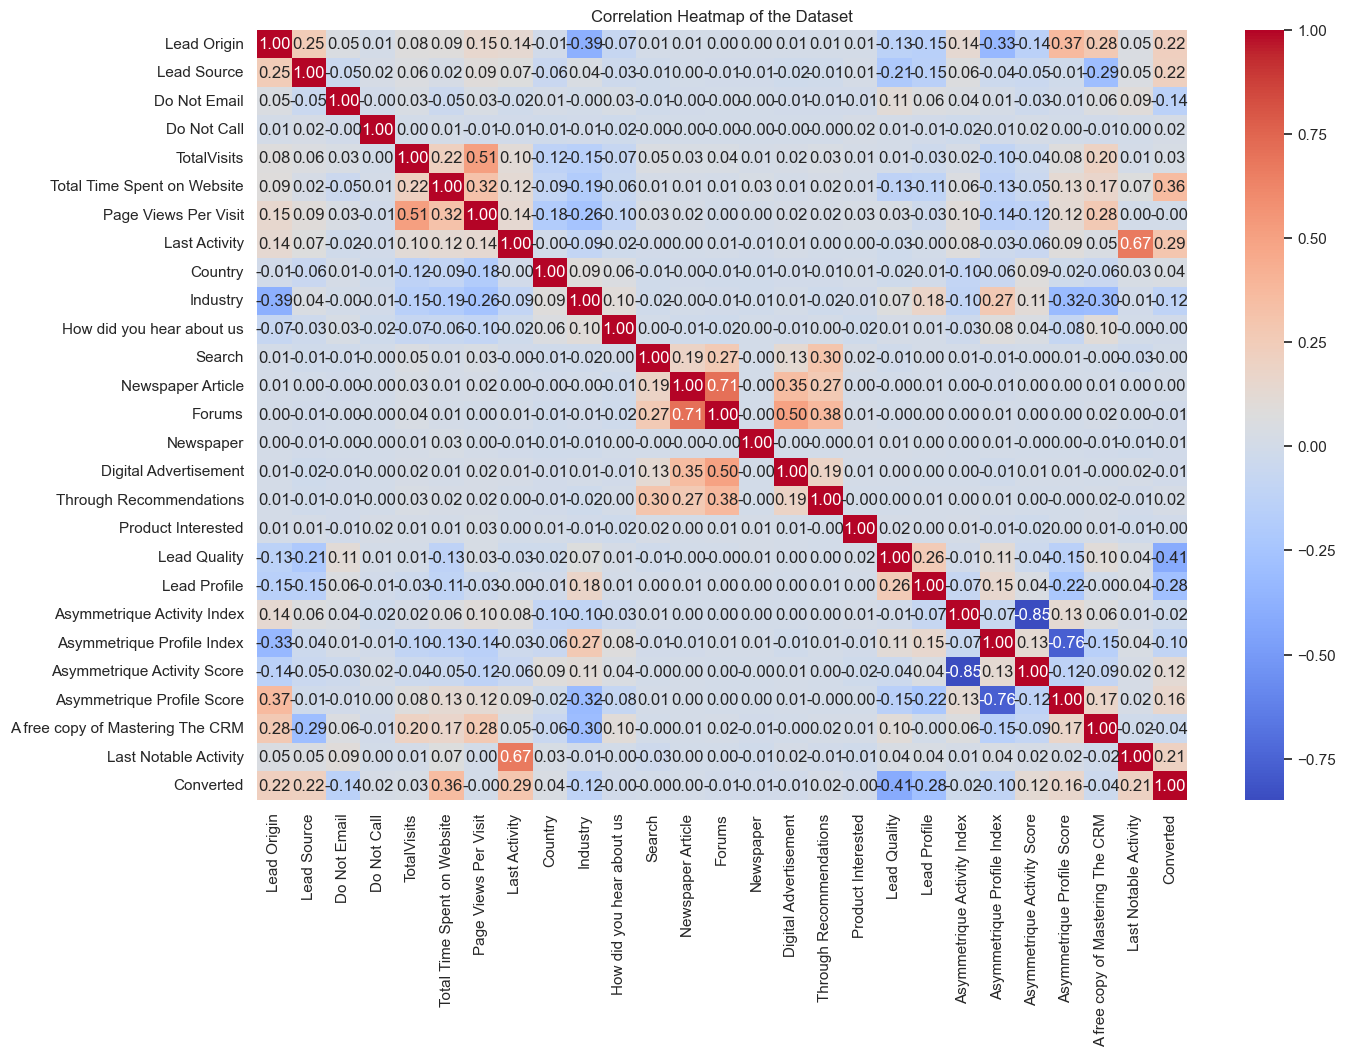

In [278]:
# Correlation Matrix

correlation_matrix = df.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of the Dataset')
plt.show()

In [279]:
# Dropping Last Notable Activity as it is highly correlated with Last Activity
# Asymmetrique indexes are highly correlated with scores

df.drop(['Last Notable Activity', 'Asymmetrique Profile Index', 'Asymmetrique Activity Index'], axis=1, inplace=True)

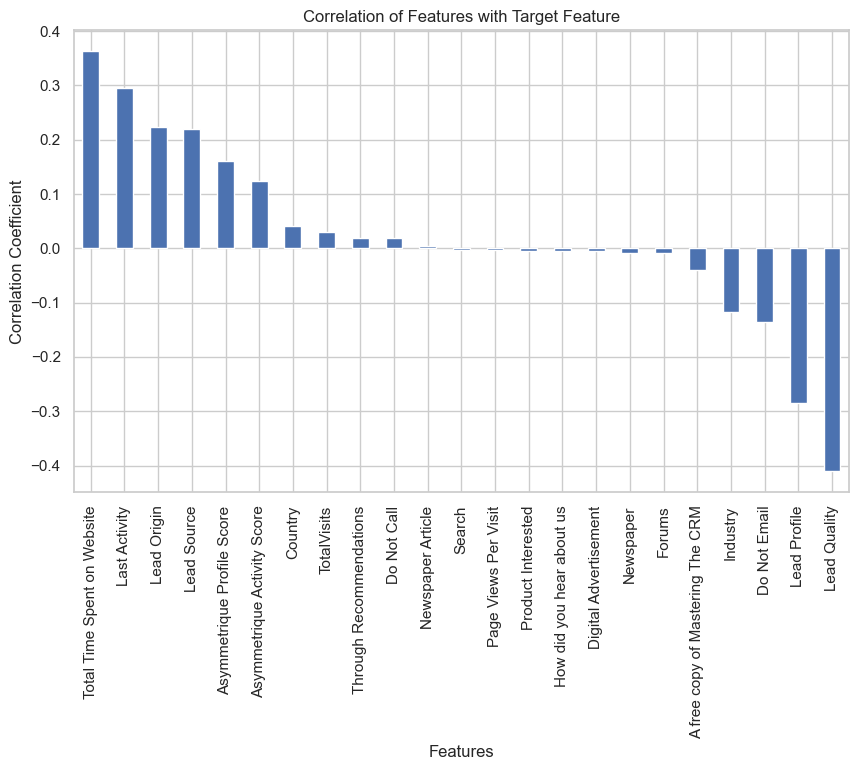

Converted                           1.000000
Total Time Spent on Website         0.362483
Last Activity                       0.294435
Lead Origin                         0.223725
Lead Source                         0.219019
Asymmetrique Profile Score          0.160700
Asymmetrique Activity Score         0.123491
Country                             0.041622
TotalVisits                         0.030091
Through Recommendations             0.018607
Do Not Call                         0.018581
Newspaper Article                   0.003465
Search                             -0.002261
Page Views Per Visit               -0.003294
Product Interested                 -0.004704
How did you hear about us          -0.004748
Digital Advertisement              -0.005789
Newspaper                          -0.008238
Forums                             -0.008238
A free copy of Mastering The CRM   -0.039820
Industry                           -0.117986
Do Not Email                       -0.135580
Lead Profi

In [280]:
# Extracting correlations with target variable

correlation_matrix_dropped = df.corr()

converted_correlations = correlation_matrix_dropped['Converted'].sort_values(ascending=False)

# Plotting the correlations with target variable
plt.figure(figsize=(10, 6))
converted_correlations.drop('Converted').plot(kind='bar')
plt.title('Correlation of Features with Target Feature')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.show()

converted_correlations

In [281]:
# Select features

selected_features = ['Total Time Spent on Website', 'Last Activity', 'Lead Origin', 'Lead Source', 'Do Not Email', 'Asymmetrique Profile Score', 'Lead Profile', 'Lead Quality']

In [282]:
# Numerical and categorical features

numerical_features = ['Total Time Spent on Website', 'Asymmetrique Profile Score', 'Do Not Email']

categorical_features = ['Last Activity', 'Lead Origin', 'Lead Source', 'Lead Profile', 'Lead Quality']

In [283]:
# Split the data

X = df[numerical_features + categorical_features]
y = df['Converted']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [284]:
# Transformers

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [285]:
# Preprocessing

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

**Baseline Model - Logistic Regression**

In [286]:
# Create a logistic regression pipeline

logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Train the model with training data

logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Total Time Spent on '
                                                   'Website',
                                                   'Asymmetrique Profile Score',
                                                   'Do Not Email']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Last Activity',
                                                   'Lead Origin', 'Lead Source',
                                                   'Lead Profile',
                                                   'Lead Quality'])])),
                ('classifier', LogisticRegression())])

In [287]:
# Make predictions with testing data

y_pred = logreg_pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_rep)

Accuracy: 0.8371
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.90      0.87      1107
         1.0       0.83      0.75      0.79       741

    accuracy                           0.84      1848
   macro avg       0.84      0.82      0.83      1848
weighted avg       0.84      0.84      0.84      1848



Confusion Matrix

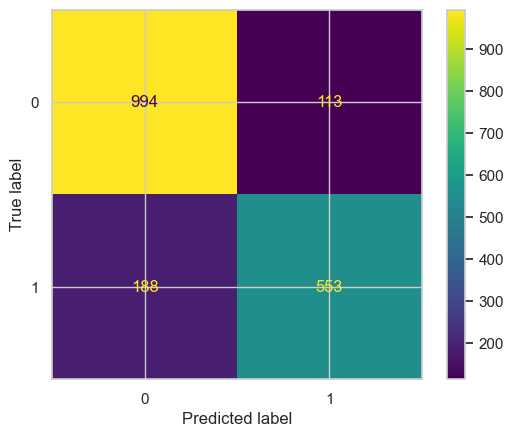

In [288]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
conf_matrix.plot()
plt.show()

**Random Forest**

Best parameters: {'random_forest__max_depth': 10, 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 2, 'random_forest__n_estimators': 50}

In [289]:
# Create a Random Forest classifier pipeline

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('random_forest', RandomForestClassifier(random_state=42, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50))
])

# Train the pipeline (including preprocessing and classifier training)

rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Total Time Spent on '
                                                   'Website',
                                                   'Asymmetrique Profile Score',
                                                   'Do Not Email']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Last Activity',
                                                   'Lead Origin', 'Lead Source',
                                                   'Lead Profile',
                                                   'Lead Quality'])])),
                ('random_forest',
                 RandomForestClassifier(max_depth=10, n_estimators=50,
                                        random_state=42))])

In [290]:
# Make predictions with testing data

y_pred = rf_pipeline.predict(X_test)

# Evaluate the model

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_rep)

Accuracy: 0.8469
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.92      0.88      1107
         1.0       0.86      0.74      0.79       741

    accuracy                           0.85      1848
   macro avg       0.85      0.83      0.84      1848
weighted avg       0.85      0.85      0.84      1848



Confusion Matrix

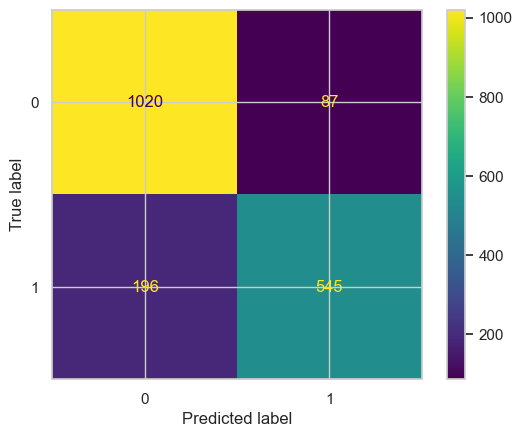

In [291]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
conf_matrix.plot()
plt.show()

**XGBoost Model**

Best parameters: {'xgboost_classifier__learning_rate': 0.1, 'xgboost_classifier__max_depth': 3, 'xgboost_classifier__n_estimators': 200}

In [292]:
# Create an XGBoost classifier pipeline

xgboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgboost_classifier', XGBClassifier(random_state=42, learning_rate=0.1, max_depth=3, n_estimators=200))
])

# Train the pipeline (including preprocessing and classifier training)

xgboost_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Total Time Spent on '
                                                   'Website',
                                                   'Asymmetrique Profile Score',
                                                   'Do Not Email']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Last Activity',
                                                   'Lead Origin', 'Lead Source',
                                                   'Lead Profile',
                                                   'Lead Quality'])])),
                ('xgboost_cl...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [293]:
# Make predictions with testing data

y_pred = xgboost_pipeline.predict(X_test)

# Evaluate the model

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:\n', classification_rep)

Accuracy: 0.8496
Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.89      0.88      1107
         1.0       0.83      0.79      0.81       741

    accuracy                           0.85      1848
   macro avg       0.85      0.84      0.84      1848
weighted avg       0.85      0.85      0.85      1848



Confusion Matrix

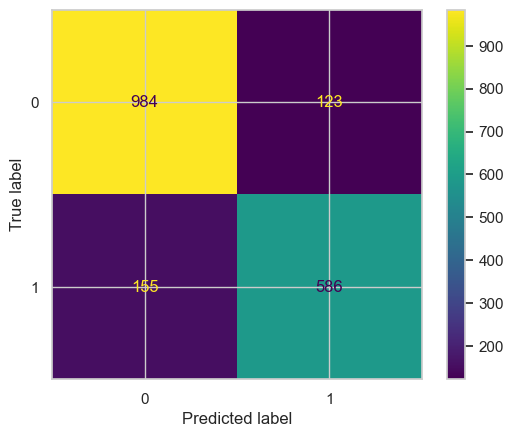

In [294]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
conf_matrix.plot()
plt.show()

**ROC-AUC Curve Comparison**

In [295]:
# Predict probabilities for each model

y_pred_prob_logreg = logreg_pipeline.predict_proba(X_test)[:, 1]
y_pred_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]
y_pred_prob_xgboost = xgboost_pipeline.predict_proba(X_test)[:, 1]

In [296]:
# Calculate ROC curve and AUC for each model

fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_prob_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgboost, tpr_xgboost, _ = roc_curve(y_test, y_pred_prob_xgboost)
roc_auc_xgboost = auc(fpr_xgboost, tpr_xgboost)

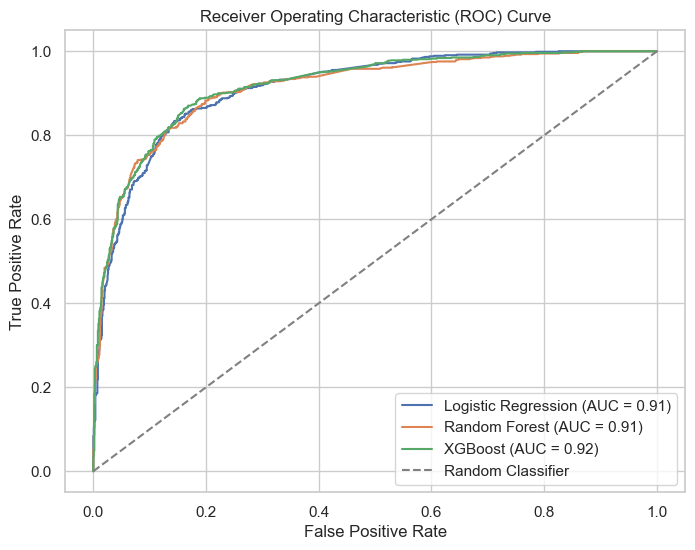

In [297]:
# Plot the ROC curves

plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_xgboost, tpr_xgboost, label=f'XGBoost (AUC = {roc_auc_xgboost:.2f})')

# Plot the 45-degree line (random classifier)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')

# Set labels and title

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

**Precision-Recall Curve**

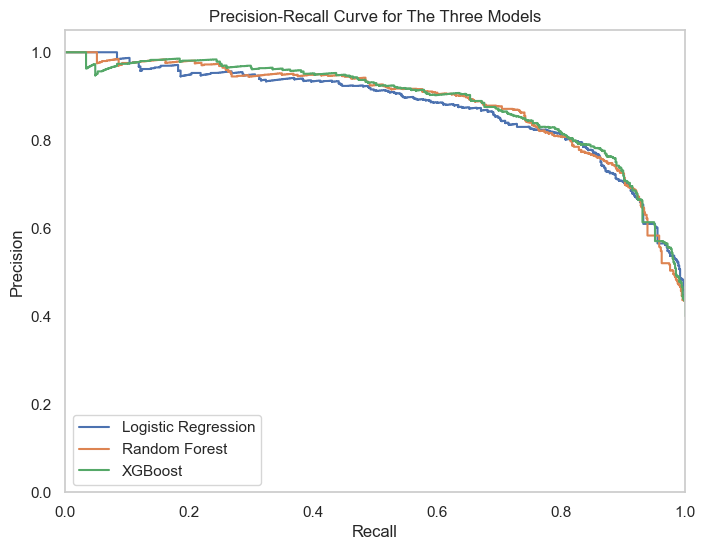

In [298]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Make predictions on your test data

y_pred1 = logreg_pipeline.predict_proba(X_test)[:, 1]
y_pred2 = rf_pipeline.predict_proba(X_test)[:, 1]
y_pred3 = xgboost_pipeline.predict_proba(X_test)[:, 1]

# Step 3: Calculate precision and recall values at different thresholds
precision1, recall1, _ = precision_recall_curve(y_test, y_pred1)
precision2, recall2, _ = precision_recall_curve(y_test, y_pred2)
precision3, recall3, _ = precision_recall_curve(y_test, y_pred3)

# Step 4: Plot the precision-recall curves
plt.figure(figsize=(8, 6))
plt.step(recall1, precision1, where='post', label='Logistic Regression')
plt.step(recall2, precision2, where='post', label='Random Forest')
plt.step(recall3, precision3, where='post', label='XGBoost')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for The Three Models')
plt.legend(loc='best')
plt.grid()
plt.show()

**GridSearch CV - Random Forest**

In [299]:
from sklearn.model_selection import GridSearchCV

# rf_model
# which includes both preprocessing and the classifier

model = rf_pipeline

# Define the parameter grid to search
param_grid = {
    'random_forest__n_estimators': [50, 100, 200],
    'random_forest__max_depth': [None, 10, 20, 30],
    'random_forest__min_samples_split': [2, 4],
    'random_forest__min_samples_leaf': [1, 2]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=3,  # 3-fold cross-validation
                           n_jobs=-1,  # Use all available cores
                           verbose=2)

In [300]:
# Perform the grid search on the training data

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Total '
                                                                          'Time '
                                                                          'Spent '
                                                                          'on '
                                                                          'Website',
                                                                          'Asymmetrique '
                                                                          'Profile '
                                                                          'Score',
                                                                          'Do '
                                                                          'Not '
                                                                          'Email']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Last '
                                                                          'Activity',
                                                                          'Lead '
                                                                          'Origin',
                                                                          'Lead '
                                                                          'Source',
                                                                          'Lead '
                                                                          'Profile',
                                                                          'Lead '
                                                                          'Quality'])])),
                                       ('random_forest',
                                        RandomForestClassifier(max_depth=10,
                                                               n_estimators=50,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'random_forest__max_depth': [None, 10, 20, 30],
                         'random_forest__min_samples_leaf': [1, 2],
                         'random_forest__min_samples_split': [2, 4],
                         'random_forest__n_estimators': [50, 100, 200]},
             verbose=2)

In [301]:
# Show best parameters

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters:", best_params)

Best parameters: {'random_forest__max_depth': 10, 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 2, 'random_forest__n_estimators': 50}


**Grid Search CV - XGBoost**

In [302]:
# XGBoost Model

model = xgboost_pipeline

# Define the parameter grid to search

param_grid = {
    'xgboost_classifier__max_depth': [3, 4, 5],
    'xgboost_classifier__n_estimators': [100, 200],
    'xgboost_classifier__learning_rate': [0.01, 0.1, 0.2]
}

# Create a GridSearchCV object

grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=3,  # 3-fold cross-validation
                           n_jobs=-1,  # Use all available cores
                           verbose=2)

In [303]:
# Perform the grid search on the training data

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Total '
                                                                          'Time '
                                                                          'Spent '
                                                                          'on '
                                                                          'Website',
                                                                          'Asymmetrique '
                                                                          'Profile '
                                                                          'Score',
                                                                          'Do '
                                                                          'Not '
                                                                          'Email']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Last '
                                                                          'Activity',
                                                                          'Lead '
                                                                          'Origin',
                                                                          'Lead '
                                                                          'Sourc...
                                                      max_depth=3,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=200,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgboost_classifier__learning_rate': [0.01, 0.1, 0.2],
                         'xgboost_classifier__max_depth': [3, 4, 5],
                         'xgboost_classifier__n_estimators': [100, 200]},
             verbose=2)

In [304]:
# Show best parameters

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters:", best_params)

Best parameters: {'xgboost_classifier__learning_rate': 0.1, 'xgboost_classifier__max_depth': 3, 'xgboost_classifier__n_estimators': 200}


**Feature Importance**

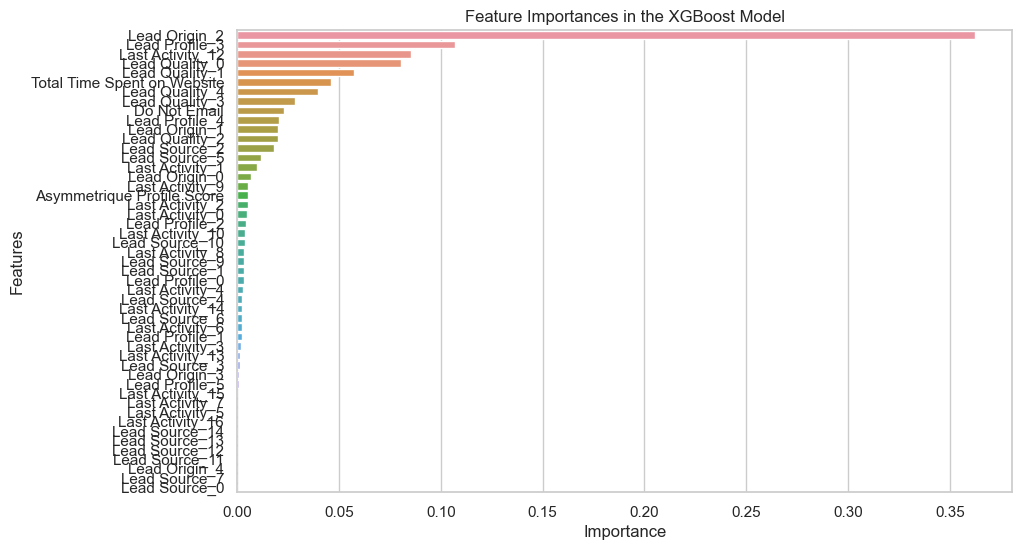

In [305]:
# Accessing the XGBoost inside the pipeline

xgboost_classifier = xgboost_pipeline.named_steps['xgboost_classifier']

# Extracting feature importances

feature_importances = xgboost_classifier.feature_importances_

# Getting feature names after preprocessing
# For numerical features, the names stay the same
# For categorical features, we need to transform them using the one-hot encoder

ohe = xgboost_pipeline.named_steps['preprocessor'].named_transformers_['cat']
ohe_columns = ohe.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(ohe_columns)

# Creating a Series for easy plotting

importances = pd.Series(feature_importances, index=feature_names)

# Sorting importances

sorted_importances = importances.sort_values(ascending=False)

# Plotting

plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances, y=sorted_importances.index)
plt.title('Feature Importances in the XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

**Export Best Model**

In [306]:
import joblib

# Save XGBoost model to file

joblib.dump(xgboost_pipeline, 'xgboost_classifier.joblib')

['xgboost_classifier.joblib']

loaded_model = joblib.load('xgboost_classifier.joblib')